In [9]:
import numpy as np
import pulp as pulp
from pulp import *
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.stats as stats
from joblib import Parallel, delayed

In [15]:
#The following function solves the LP of the corresponding N-armed RB
def solve_lp_standard(P0,P1,R0,R1,alpha_list,T,init,print_res=False):
    n = len(R0)
    P = [P0,P1]
    R = [R0,R1]
    action = range(0,2)
    state = range(0,n)
    horizon = range(0,T)
    prob = LpProblem("LP1", LpMaximize)
    variables = LpVariable.dicts("Y",(horizon,action,state),lowBound=0., upBound=1.)
    # resource constraints
    for t in horizon:
        prob += lpSum([variables[t][1][s] for s in state]) == alpha_list[t]
    # Markov state evolution
    for t in range(0,T-1):
        for s in state:
            prob += lpSum(variables[t+1][a][s] for a in action) == lpSum([variables[t][a][ss]*P[a][ss][s] for a in action for ss in state])
    # initial condition        
    for s in state:
        prob += lpSum(variables[0][a][s] for a in action) == init[s]
    # objective    
    prob += lpSum([variables[t][a][s]*R[a][s] for t in horizon for a in action for s in state])
    
    prob.solve()
    
    if print_res:
        print("Optim Value is " + str(value(prob.objective)))
    
    y = np.zeros((T,2,n))
    for t in horizon:
        for a in action:
            for s in state:
                V = variables[t][a][s]
                y[t,a,s] = V.varValue
    return y

#The following function counts the NoR of the LP solution
def randomization_numbers(P0,P1,R0,R1,alpha_list,T,init):
    n = len(R0)
    P = [P0,P1]
    R = [R0,R1]
    action = range(0,2)
    state = range(0,n)
    horizon = range(0,T)
    prob = LpProblem("LP1", LpMaximize)
    variables = LpVariable.dicts("Y",(horizon,action,state),lowBound=0., upBound=1.)
    # resource constraints
    for t in horizon:
        prob += lpSum([variables[t][1][s] for s in state]) == alpha_list[t]
    # Markov state evolution
    for t in range(0,T-1):
        for s in state:
            prob += lpSum(variables[t+1][a][s] for a in action) == lpSum([variables[t][a][ss]*P[a][ss][s] for a in action for ss 
                                                                          in state])
    # initial condition        
    for s in state:
        prob += lpSum(variables[0][a][s] for a in action) == init[s]
    # objective    
    prob += lpSum([variables[t][a][s]*R[a][s] for t in horizon for a in action for s in state])
    
    prob.solve()
    
    y = np.zeros((T,2,n))
    randomization_nb = np.zeros(T, dtype=int)
    for t in horizon:
        for a in action:
            for s in state:
                V = variables[t][a][s]
                y[t,a,s] = V.varValue
    for t in horizon:
        randomization_count = 0
        for s in state:
            if y[t,0,s] > 1e-8 and y[t,1,s] > 1e-8:
                randomization_count += 1
        randomization_nb[t] = randomization_count
    return randomization_nb

#Implementation of the SAA
def solve_c_ssa(N, P0, P1, R0, R1, T, y, randomness, nb_samples):
    n = len(R0)
    P = [P0,P1]
    R = [R0,R1]
    action = range(0,2)
    state = range(0,n)
    horizon = range(0,T)
    prob = LpProblem("LP2", LpMaximize)
    c_first = LpVariable.dicts("c_first",(action, state))
    c = LpVariable.dicts("c",(range(0,nb_samples), range(1,T), action, state))
    coef = np.sqrt(N)
        
    for i in range(nb_samples):
        for t in range(1,T):
            prob += c[i][t][1][1] + c[i][t][1][0] == 0
            prob += c[i][t][0][1] + c[i][t][0][0] == 0
            for s in state:
                for a in action:
                    #prob += c[i][t][a][s] >= -y[t,a,s]*coef
                    if y[t,a,s] <= 1e-6:
                        prob += c[i][t][a][s] >= 0
    
    prob += c_first[1][1] + c_first[1][0] == 0
    prob += c_first[0][1] + c_first[0][0] == 0
    for s in state:
        for a in action:
            prob += c_first[a][s] >= -y[0,a,s]*coef
    prob += c_first[1][0] + c_first[0][0] == 0
    
    for t in range(1,T-1):
        const = compute_const(P0, P1, t, y)
        for i in range(nb_samples):
            prob += lpSum(c[i][t+1][a][0] for a in action) - lpSum([c[i][t][a][s]*P[a][s][0] for a in action for s in state]) == const*randomness[i,t]
    
    const = compute_const(P0, P1, 0, y)
    for i in range(nb_samples):
        prob += lpSum(c[i][1][a][0] for a in action) - lpSum([c_first[a][s]*P[a][s][0] for a in action for s in state]) == const*randomness[i,0]

    # objective    
    prob += lpSum([c[i][t][a][s]*R[a][s] for i in range(nb_samples) for t in range(1,T) for a in action for s in state]) + lpSum([c_first[a][s]*R[a][s]*nb_samples for a in action for s in state])

    prob.solve()

    c_value = np.zeros((2,n))
    for a in action:
        for s in state:
            V = c_first[a][s]
            c_value[a,s] = V.varValue
    
    return c_value[0,0]

Example 1 with T=2 and S=2

In [11]:
P1 = np.array([[0.2,0.8],[0.7,0.3]])
P0 = np.array([[0.9,0.1],[0.25,0.75]])
alpha_list = [0.5,0.5]
R0 = np.array([0,0])
R1 = np.array([1,0])
init = [0.5,0.5]
T = 2

y = solve_lp_standard(P0,P1,R0,R1,alpha_list,T,init,True)
y

Optim Value is 0.76086957


array([[[0.23913043, 0.26086957],
        [0.26086957, 0.23913043]],

       [[0.        , 0.5       ],
        [0.5       , 0.        ]]])

In [19]:
#Numerically solving for the optimal value of c*_diff
def compute_const(P0, P1, t, y):
    n = len(R0)
    P = [P0,P1]
    action = range(0,2)
    state = range(0,n)
    const = 0.
    for s in state:
        for a in action:
            const += y[t,a,s]*P[a][s][0]*(1 - P[a][s][0])
    return np.sqrt(const)

w = compute_const(P0, P1, 0, y)
pp = P1[0,0] - P1[1,0] - P0[0,0] + P0[1,0]

z = (1+1/pp)
x = stats.norm.ppf(1 - z)

c = x*w/pp
print(f"The value of c is {c:.6f}")

The value of c is -0.393986


In [35]:
#Use SSA to estimate c*_diff from c_tree
def generate_randomness(T, nb_samples):
    randomness = np.zeros((nb_samples,T-1))
    for i in range(nb_samples):
        for j in range(T-1):
            randomness[i,j] = np.random.normal(loc=0, scale=1)
    return randomness

c_list = []
nb_samples = 1000
N = 1000000
for _ in tqdm(range(100)):
    randomness = generate_randomness(T, nb_samples)
    c = solve_c_ssa(N, P0, P1, R0, R1, T, y, randomness, nb_samples)
    c_list.append(c)

mean = np.mean(c_list)
sem = np.std(c_list, ddof=1) / np.sqrt(len(c_list))  # ddof=1 for sample standard deviation

print(f"Mean: {mean}, Standard Error: {sem}")

100%|██████████| 100/100 [00:16<00:00,  5.98it/s]

Mean: -0.39319192459999996, Standard Error: 0.0017383350425571968


In [ ]:
#Compute the optimal policy by brute-force
def find_best_pull_refine(N, p1, p2, q1, q2, beta, c, nb_repeats):
    beta_shift = beta - c/np.sqrt(N)
    half_N = int(N/2)
    beta_N = int(beta_shift*N)
    proba_normal = beta_shift*N - beta_N
    candidate_proba = np.arange(0, 1, 0.002)
    record_proba = 0.
    record_perf = 0.
    for proba in tqdm(candidate_proba):
        Perf = []
        for _ in range(nb_repeats):
            Z = beta_N + np.random.binomial(1, proba)
            G = (np.random.binomial(Z, p1) + np.random.binomial(half_N - Z, q1) + np.random.binomial(half_N - Z, p2) + np.random.binomial(Z, q2))
            perf = Z + min(half_N, G)
            Perf.append(perf)
        Perf_mean = np.mean(Perf)
        if Perf_mean > record_perf:
            record_proba = proba
            record_perf = Perf_mean
    print(f"N is {N}: perf is {record_perf/N:6f}")
    print(proba_normal, record_proba)
    return record_perf/N

p1 = P1[0,0]
p2 = P1[1,0]
q1 = P0[0,0]
q2 = P0[1,0]

myN = np.arange(10,90,10)
nb_repeats = 100000
beta = 0.26086957

c = -0.393986

for N in myN:
    find_best_pull_refine(N, p1, p2, q1, q2, beta, c, nb_repeats)

In [ ]:
# Record the computation below

opt_mean = [0.733776, 0.741968, 0.745421, 0.747446, 0.749019, 0.750013, 0.750796, 0.751424]

In [ ]:
#Compute the value of the LP based and Diffusion based policies

myN = np.arange(10,90,10)
nb_repeats = 4000
for N in myN:
    y_shift = LP_approximation_first_pull_fraction(N, P0,P1,R0,R1, alpha_list, T, init)
    LP_approximation_simulation_repeat(N, P0,P1,R0,R1, alpha_list, T, init, y_shift, nb_repeats)
    y_shift = normal_approximation_first_pull_fraction(N, P0,P1,R0,R1, alpha_list, T, init)
    normal_approximation_simulation_repeat(N, P0,P1,R0,R1, alpha_list, T, init, y_shift, nb_repeats)

In [ ]:
# Record the computation below

LP_mean = [0.704875, 0.724225, 0.731592, 0.735425, 0.737115, 0.740279, 0.741246, 0.742931]
normal_mean = [0.730050, 0.741537, 0.745500, 0.746550, 0.747415, 0.748392, 0.750775, 0.751306]

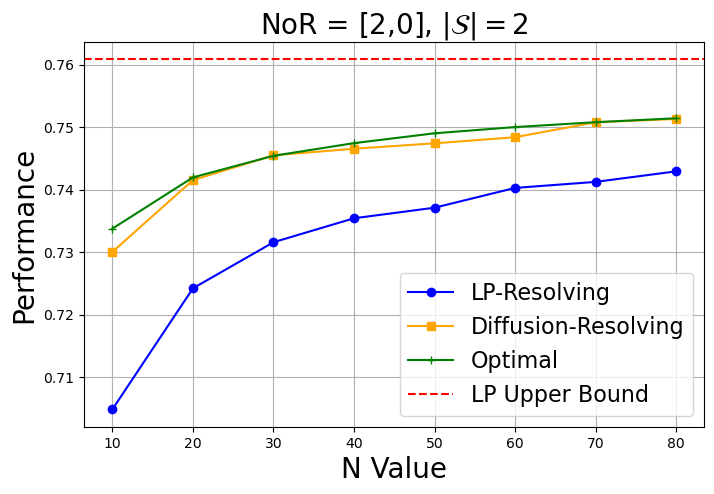

In [44]:
# Plot the figure
myN = np.arange(10, 90, 10)
LP_mean = [0.704875, 0.724225, 0.731592, 0.735425, 0.737115, 0.740279, 0.741246, 0.742931]
normal_mean = [0.730050, 0.741537, 0.745500, 0.746550, 0.747415, 0.748392, 0.750775, 0.751306]
opt_mean = [0.733776, 0.741968, 0.745421, 0.747446, 0.749019, 0.750013, 0.750796, 0.751424]
upper = 0.76086957

# Plotting the data
plt.figure(figsize=(8, 5))  # Set the figure size (optional)
plt.plot(myN, LP_mean, label='LP-Resolving', marker='o', color = 'blue')  # Plot LP_mean with markers
plt.plot(myN, normal_mean, label='Diffusion-Resolving', marker='s', color = 'orange')  # Plot normal_mean with markers
plt.plot(myN, opt_mean, label='Optimal', marker='+', color = 'green')  # Plot optimal with markers

# Adding a horizontal dotted line for LP_upper
plt.axhline(y=upper, color='r', linestyle='--', label='LP Upper Bound')

# Adding titles and labels
# plt.title('Comparison of LP-update and normal-update: type = [2,0]',fontsize=15)
plt.title('NoR = [2,0], $|\mathcal{S}| = 2$',fontsize=20)
plt.xlabel('N Value',fontsize=20)
plt.ylabel('Performance',fontsize=20)
plt.xticks(myN)  # Ensure that all x-ticks are shown

# Adding a legend
plt.legend(fontsize=16)

# Show the plot
plt.grid(True)

#plt.savefig("LP vs normal 2.pdf")

Example 2 with T=3 and S=4

In [ ]:
#This cell collects the functions to run simulation of the diffusion-resolving policy

def compute_Sigma(P0, P1, t, y):
    n = len(P0[0])
    P = np.array([P0,P1])
    A = 2
    action = range(0,A)
    state = range(0,n)
    Sigma_all = np.zeros((n,A,n,n))
    Sigma = np.zeros((n,n))            
    for s in state:
        for a in action:
            for i in state:
                for j in state:
                    if i == j:
                        Sigma_all[s,a,i,j] = P[a,s,i]*(1 - P[a,s,i])
                    else:
                        Sigma_all[s,a,i,j] = -P[a,s,i]*P[a,s,j]
    for i in state:
        for j in state:
            const = 0.
            for s in state:
                for a in action:
                    const += y[t,a,s]*Sigma_all[s,a,i,j]
            Sigma[i,j] = const
    
    return Sigma

def generate_randomness(P0, P1, T, y, nb_samples_per_step):
    def extend_one_step(current_randomness, P0, P1, t, y, nb_samples_per_step):
        n = len(P0[0])
        mean = np.zeros(n)
        next_randomness = []
        Sigma = compute_Sigma(P0, P1, t, y)
        for item in current_randomness:
            for _ in range(nb_samples_per_step):
                next_item_copy = item.copy()
                one_randomness = np.random.multivariate_normal(mean, Sigma)
                next_item_copy.append(one_randomness)
                next_randomness.append(next_item_copy)
        return next_randomness
    
    current_randomness = [[]]
    for t in range(T-1):
        current_randomness_copy = current_randomness.copy()
        current_randomness = extend_one_step(current_randomness_copy, P0, P1, t, y, nb_samples_per_step)
    
    return current_randomness

def first_pull_fraction(N, P0, P1, R0, R1, alpha_list, T, init, refine, nb_samples_per_step):
    n = len(R0)
    state = range(0,n)
    y = solve_lp_standard(P0,P1,R0,R1,alpha_list,T,init)
    if not refine:
        return y[0][1]
    
    randomization_count = 0
    for s in state:
        if y[0,0,s] > 1e-8 and y[0,1,s] > 1e-8:
            randomization_count += 1
    if T < 2 or randomization_count < 2:
        return y[0][1]
    
    #if T < 2:
        #return y[0][1]
    
    c_list = []
    for _ in range(100):
        randomness = generate_randomness(P0, P1, T, y, nb_samples_per_step)
        c = solve_c_ssa(N, P0, P1, R0, R1, T, y, randomness, nb_samples_per_step)
        if np.any(c != None): 
                c_list.append(c)
    if len(c_list) == 0:
        return y[0][1]
    
    c_mean = sum(c_list)/len(c_list)
    y_0 = y[0] + c_mean/np.sqrt(N)
    
    if np.any(y_0 < 0):
        return y[0][1]
    
    return y_0[1]

def first_pull_number(N, y_first, alpha):
    n = len(y_first)
    state = range(0,n)
    Y = np.zeros(n, dtype = int)
    M = int(round(N*alpha))
    pull_frac = np.zeros(n)
    for s in state:
        Ns = N*y_first[s]
        Y[s] = int(round(Ns))
        pull_frac[s] = Ns - Y[s]
    pull_frac_total = M - sum(Y)
    if pull_frac_total == 0:
        return Y
    else:
        # randomized rounding
        pull_frac_proba = pull_frac/sum(pull_frac)
        pull_frac_number = np.random.multinomial(pull_frac_total, pull_frac_proba)
        return Y + pull_frac_number

def resolve_one_simulation(N, P0, P1, R0, R1, alpha_list, T, init, y_first, refine):
    n = len(R0)
    state = range(0,n)
    total_reward = 0.
    
    while T > 0:  
        alpha = alpha_list[0]
        pull_number = first_pull_number(N, y_first, alpha)
        X_next = np.zeros(n, dtype = int)
        gain = 0.
        for s in state:
            Xs = int(round(N*init[s]))
            Ys = pull_number[s]
            X_next += np.random.multinomial(Xs - Ys, P0[s]) + np.random.multinomial(Ys, P1[s])
            gain += (Xs - Ys)*R0[s] + Ys*R1[s]
        total_reward += gain
        
        # update the system information
        alpha_list = alpha_list[1:]
        T -= 1
        init = X_next/N
        if T > 0:
            y_first = first_pull_fraction(N, P0, P1, R0, R1, alpha_list, T, init, refine, nb_samples_per_step)

    return total_reward/N

def resolve_simulation_repeat(N, P0, P1, R0, R1, alpha_list, T, init, y_first, refine, nb_repeats, more_info = False):
    # Define the simulation task as a separate function that can be parallelized
    def simulation_task():
        return resolve_one_simulation(N, P0, P1, R0, R1, alpha_list, T, init, y_first, refine)
    
    # Run the simulations in parallel
    res = Parallel(n_jobs=-1)(delayed(simulation_task)() for _ in tqdm(range(nb_repeats)))
    
    mean = np.mean(res)
    sem = np.std(res, ddof=1) / np.sqrt(len(res))  # ddof=1 for sample standard deviation
    if refine:
        print(f"N = {N}: normal-update Mean: {mean:6f}, Standard Error: {sem:6f}")
    else:
        print(f"N = {N}: LP-update Mean: {mean:6f}, Standard Error: {sem:6f}")
    if more_info:
        return mean, sem
    return mean


In [30]:
#An example with 4 states and horizon is 3. The NoR is [2,1,0] hence is degenerate

P0 = np.array([[0.04616014, 0.95383986, 0., 0.], [0.97940986, 0.02059014, 0., 0.], [0.6784394 , 0., 0., 0.3215606 ], [0.39063249, 0., 0., 0.60936751]])
P1 = np.array([[0., 0., 0.70312733, 0.29687267], [0., 0.31194073, 0., 0.68805927], [0.02132633, 0., 0.97867367, 0.], [0., 0., 0.67297035, 0.32702965]])
R0 = np.array([0.19597391, 0.20564447, 0.12924194, 0.72711124])
R1 = np.array([0.72696503, 0.4554153 , 0.12720632, 0.5138001 ])
init = np.array([0.4, 0.6, 0. , 0. ])

T = 3
alpha_list = [0.5]*T

y = solve_lp_standard(P0,P1,R0,R1,alpha_list,T,init)
NoR = randomization_numbers(P0,P1,R0,R1,alpha_list,T,init)
print(NoR)

[2 1 0]


In [ ]:
#Rerun the simulation if necessary

myN = np.arange(10,90,10)
nb_repeats = 4000
LP_mean = []
normal_mean = []

for N in myN:
    for refine in [False, True]:
        y_first = first_pull_fraction(N, P0, P1, R0, R1, alpha_list, T, init, refine)
        res = resolve_simulation_repeat(N, P0, P1, R0, R1, alpha_list, T, init, y_first, refine, nb_repeats)
        if refine == False:
            LP_mean.append(res)
        else:
            normal_mean.append(res)
        gap = (upper-res)*np.sqrt(N)
        print("gap is " + str(gap))  

In [ ]:
#Record the simulation results

LP_mean = np.array([1.88470525, 1.9017005, 1.9114291666666667, 1.9265088125000003, 1.92862645, 1.9288081666666668, 1.9297914642857146, 1.9306028437500002])
normal_mean = np.array([1.9093205, 1.9203225, 1.928836416666667, 1.9325306249999998, 1.93491865, 1.9371005000000003, 1.937666892857143, 1.93844521875])

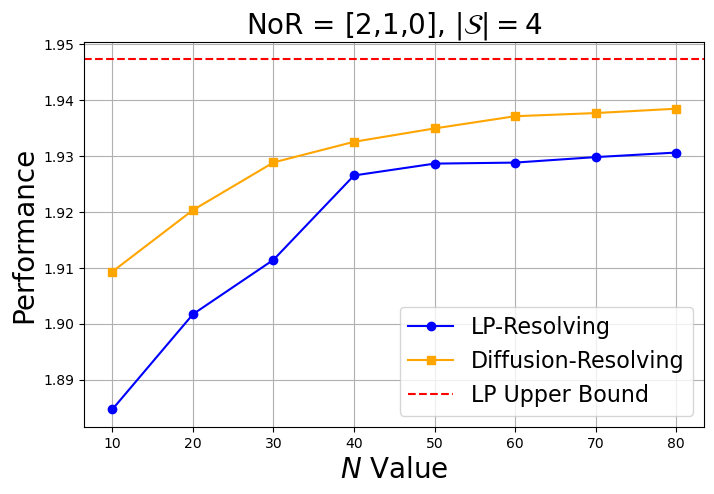

In [34]:
# Plot the figure
myN = np.arange(10, 90, 10)

LP_mean = np.array([1.88470525, 1.9017005, 1.9114291666666667, 1.9265088125000003, 1.92862645, 1.9288081666666668, 1.9297914642857146, 1.9306028437500002])
normal_mean = np.array([1.9093205, 1.9203225, 1.928836416666667, 1.9325306249999998, 1.93491865, 1.9371005000000003, 1.937666892857143, 1.93844521875])

upper = 1.9472951889

# Plotting the data
plt.figure(figsize=(8, 5))  # Set the figure size (optional)
plt.plot(myN, LP_mean, label='LP-Resolving', marker='o', color = 'blue')  # Plot LP_mean with markers
plt.plot(myN, normal_mean, label='Diffusion-Resolving', marker='s', color = 'orange')  # Plot normal_mean with markers

# Adding a horizontal dotted line for LP_upper
plt.axhline(y=upper, color='r', linestyle='--', label='LP Upper Bound')

# Adding titles and labels
plt.title('NoR = [2,1,0], $|\mathcal{S}| = 4$',fontsize=20)
plt.xlabel('$N$ Value',fontsize=20)
plt.ylabel('Performance',fontsize=20)
plt.xticks(myN)  # Ensure that all x-ticks are shown

# Adding a legend
plt.legend(fontsize=16)

# Show the plot
plt.grid(True)

#plt.savefig("LP vs normal 3.pdf")

In [ ]:
#Simulation with larger values of N

myN = np.arange(100,1600,100)
nb_repeats = 10000
LP_gap = []
normal_gap = []
LP_ci = []
normal_ci = []

for N in myN:
    for refine in [False, True]:
        y_first = first_pull_fraction(N, P0, P1, R0, R1, alpha_list, T, init, refine, nb_samples_per_step)
        res, sem = resolve_simulation_repeat(N, P0, P1, R0, R1, alpha_list, T, init, y_first, refine, nb_repeats, True)
        gap = (upper-res)*np.sqrt(N)
        ci = sem*np.sqrt(N)
        print("gap is " + str(gap))
        if refine == False:
            LP_gap.append(gap)
            LP_ci.append(ci)
        else:
            normal_gap.append(gap)
            normal_ci.append(ci)

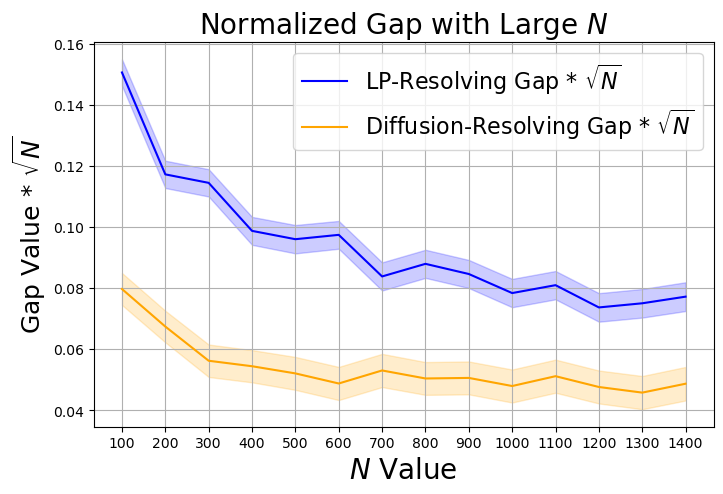

In [39]:
#Record the simulation results and plot the figure

myN = np.arange(100, 1500, 100)
LP_gap = np.array([0.1506574890000012, 0.11729110964093488, 0.11451388500455709, 0.0987950280000005, 0.09606592785260053, 0.0974919510088088, 0.08387353795195877, 0.08800050382148192, 0.08467453366667321, 0.07843213552182388, 0.08101799147776749, 
                   0.07373018934660366, 0.07508620355570082, 0.07725844889535813])
normal_gap = np.array([0.07976228899999827, 0.06746907294531157, 0.056272290959413225, 0.05447922799999727, 0.05213032258989415, 0.04882944880760981, 0.05309260262389111, 0.05047222562356111, 0.05065380033332678, 0.04800052566917726, 
                      0.05121814788756538, 0.0476826855419594, 0.04584143848534924, 0.04875474345802326])
LP_ci = np.array([0.0021658099192045028, 0.002236148485379353, 0.002234388519908252, 0.002285333863996846, 0.00232079525422994, 0.002276951940596604, 0.002303088558083483, 0.0023027236506561145, 0.0022998573569564472, 0.002320458268182506,
                 0.0023183444531326225, 0.002337099762228715, 0.002341491219826115, 0.002356199843398851])
normal_ci = np.array([0.0026204900728692337, 0.002585565630163407, 0.002655284103596528, 0.0026402452713221616, 0.002695609825643952, 0.0027118645514333907, 0.002717909312093821, 0.0026841618378987686, 0.0026914032137529474, 0.0027023860726521813,
                     0.002709998986848582, 0.0026967532650594723, 0.002718560413239889, 0.00274610572736962])


# Plotting the data with error bands
plt.figure(figsize=(8, 5))

# Plot LP_gap with error bands
plt.plot(myN, LP_gap, label='LP-Resolving Gap * $\sqrt{N}$', color='blue')
plt.fill_between(myN, LP_gap - 2*LP_ci, LP_gap + 2*LP_ci, color='blue', alpha=0.2)

# Plot normal_gap with error bands
plt.plot(myN, normal_gap, label='Diffusion-Resolving Gap * $\sqrt{N}$', color='orange')
plt.fill_between(myN, normal_gap - 2*normal_ci, normal_gap + 2*normal_ci, color='orange', alpha=0.2)

# Adding titles and labels
plt.title('Normalized Gap with Large $N$', fontsize=20)
plt.xlabel('$N$ Value', fontsize=20)
plt.ylabel(r'Gap Value * $\sqrt{N}$', fontsize=18)
plt.xticks(myN)  # Ensure that all x-ticks are shown

# Adding a legend
plt.legend(fontsize=16)

# Show the plot
plt.grid(True)


#plt.savefig("LP vs normal 4.pdf")